In [ ]:
import sys
import pandas as pd
from pandas import read_csv
import numpy
from numpy import array
import matplotlib.pyplot as plt
import math
import tensorflow
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive



Historia=1  
            
EPOCAS=5
BATCHSIZE=1
LSTM_dim=1  

In [ ]:
print (sys.version_info)
print ("NumPy: ", numpy.__version__)
print ("Pandas: ", pd.__version__)
print ("TensorFlow: ", tensorflow.__version__)
print ("Keras: ", keras.__version__)
print ("SciKitLearn: ", sklearn.__version__)


sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)
NumPy:  1.23.1
Pandas:  1.4.3
TensorFlow:  2.13.0
Keras:  2.13.1
SciKitLearn:  1.1.1


## Carga de los datos

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/AEMET-2019.xlsx'
dfAEMETVa=pd.read_excel (path)



dfAEMETVa.rename(columns = {'Fecha y hora oficial':'FechaHora', 'Velocidad del viento (km h)':'VelV',
                     'Dirección del viento':"DirV", 'Racha (km h)':'VelRacha', 'Dirección de racha':'DirRacha',
                     'Humedad (%)':'Humedad'}, inplace=True)

dfAEMETVa.sort_values(['FechaHora'], inplace=True)
dfAEMETVa.dropna(inplace=True) 
dfAEMETVa 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,FechaHora,VelV,DirV,VelRacha,DirRacha,Humedad,Temp,Precip,PresAtm,Tend
0,2019-12-05 14:00:00.000,6,Nordeste,22,Nordeste,66,10700.0,0.0,934.1,-0.4
1,2019-12-05 15:00:00.000,8,Nordeste,26,Norte,63,10900.0,0.0,934.0,-0.9
2,2019-12-05 16:00:00.000,8,Nordeste,22,Este,65,10500.0,0.0,933.7,-0.4
3,2019-12-05 17:00:00.000,7,Norte,28,Norte,68,9600.0,0.0,934.1,0.0
4,2019-12-05 18:00:00.000,5,Norte,21,Nordeste,73,8500.0,0.0,934.5,0.5
...,...,...,...,...,...,...,...,...,...,...
3205,2020-04-27 07:00:00.000,8,Oeste,17,Oeste,87,9800.0,0.0,926.3,-0.4
3206,2020-04-27 08:00:00.000,6,Sudoeste,17,Oeste,92,9400.0,0.2,926.3,-0.1
3207,2020-04-27 09:00:00.000,8,Sudoeste,17,Oeste,90,10000.0,0.0,926.5,0.4
3208,2020-04-27 10:00:00.000,9,Oeste,24,Oeste,85,10400.0,0.0,926.7,0.4


## Funciones

In [ ]:
def CreaDatos(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
       
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)



def Visualiza (titulo2):
    # Desnormaliza
    testPredict = model.predict(testX, batch_size=BATCHSIZE)*(MaxRealY - MinRealY)/0.8 + MinRealY
    testReal=testY[:,3]*(MaxRealY - MinRealY)/0.8 + MinRealY

    # RMSE
    testScore = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    print('Test Score: %.2f RMSE' % (testScore))

    plt.plot (testPredict[0:240], label="Predic")
    plt.plot (testReal[0:240], label="Real")
    plt.legend ()
    plt.title ("Prediccion de temperatura a 1 hora.\n"+titulo2+" Historia="+str (Historia)+" Epocas="+str (EPOCAS)+ " LSTM_dim="+str (LSTM_dim))
    plt.show()
    return



## Preparación de datos

In [ ]:
#seleccion columnas
df = dfAEMETVa.iloc [:,[1,3,5,6,7,8]]

# Para escalar
MinRealY=df["Temp"].min ()
MaxRealY=df["Temp"].max ()

# Normalizar
print(df)
scaler  = MinMaxScaler (feature_range=(0.1,0.9))
dataset = scaler.fit_transform(df) 

# Conjunto entre entrenamiento y prueba.
train_size = int(len(df) * 0.67)        
test_size  = len(df) - train_size
train = dataset[0:train_size,:]         
test  = dataset[train_size:len(df),:]   

# Preparamos datos
print(train)
trainX, trainY = CreaDatos(train, Historia)
testX, testY   = CreaDatos(test, Historia)
print(trainY)


      VelV  VelRacha  Humedad     Temp  Precip  PresAtm
0        6        22       66  10700.0     0.0    934.1
1        8        26       63  10900.0     0.0    934.0
2        8        22       65  10500.0     0.0    933.7
3        7        28       68   9600.0     0.0    934.1
4        5        21       73   8500.0     0.0    934.5
...    ...       ...      ...      ...     ...      ...
3205     8        17       87   9800.0     0.0    926.3
3206     6        17       92   9400.0     0.2    926.3
3207     8        17       90  10000.0     0.0    926.5
3208     9        24       85  10400.0     0.0    926.7
3209    11        23       73  11600.0     0.0    926.9

[3210 rows x 6 columns]
[[0.22631579 0.29487179 0.54675325 0.52269504 0.1        0.60857143]
 [0.26842105 0.33589744 0.51558442 0.52836879 0.1        0.60666667]
 [0.26842105 0.29487179 0.53636364 0.51702128 0.1        0.60095238]
 ...
 [0.16315789 0.16153846 0.76493506 0.31276596 0.1        0.63714286]
 [0.16315789 0.1512820

## LSTM para un problema de regresión



In [ ]:
print (trainX.shape)

(2147, 3, 6)


In [ ]:
# Crear el modelo
model = Sequential()
model.add(LSTM(LSTM_dim, input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1)                 32        
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1)                 32        
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY[:,3], batch_size=BATCHSIZE, epochs=EPOCAS, verbose=1)

Epoch 1/5
2147/2147 [==============================] - 8s 3ms/step - loss: 0.0192
Epoch 2/5
2147/2147 [==============================] - 5s 2ms/step - loss: 0.0139
Epoch 3/5
2147/2147 [==============================] - 5s 2ms/step - loss: 0.0090
Epoch 4/5
2147/2147 [==============================] - 6s 3ms/step - loss: 0.0061
Epoch 5/5
2147/2147 [==============================] - 5s 2ms/step - loss: 0.0047


In [ ]:
testPredict = model.predict(testX, batch_size=BATCHSIZE)*(MaxRealY - MinRealY)/0.8 + MinRealY
print(testPredict)


1057/1057 [==============================] - 4s 3ms/step
[[ 5811.8594]
 [ 6903.702 ]
 [ 9020.017 ]
 ...
 [12267.959 ]
 [12418.74  ]
 [12922.699 ]]


In [ ]:
testReal=testY[:,3]*(MaxRealY - MinRealY)/0.8 + MinRealY
print(testReal)

[ 7325.  9425. 11625. ... 13525. 13925. 15125.]


1057/1057 [==============================] - 2s 1ms/step
Test Score: 3138.17 RMSE


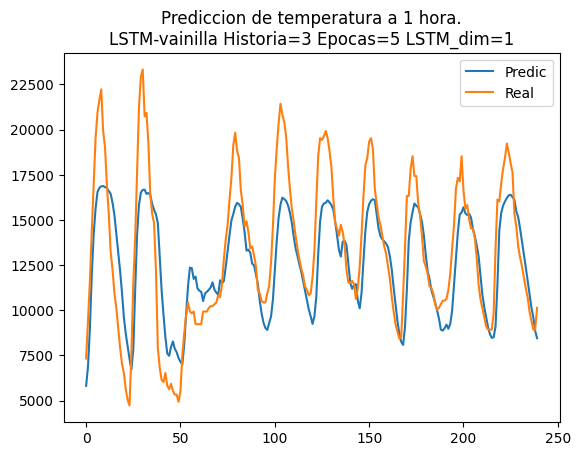

In [ ]:
Visualiza ("LSTM-vainilla")

## LSTM Utilizando una ventana temporal


In [ ]:
Historia = 3
trainX, trainY = CreaDatos (train, Historia)
testX, testY   = CreaDatos (test, Historia)

print (trainX.shape, trainY.shape)

# Crear y entrenar la red
model = Sequential()
model.add(LSTM(LSTM_dim, input_shape=(trainX.shape [1], trainX.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY[:,3], epochs=EPOCAS, batch_size=BATCHSIZE, verbose=2)


(2147, 3, 6) (2147, 6)
Epoch 1/5
2147/2147 - 7s - loss: 0.0184 - 7s/epoch - 3ms/step
Epoch 2/5
2147/2147 - 4s - loss: 0.0122 - 4s/epoch - 2ms/step
Epoch 3/5
2147/2147 - 4s - loss: 0.0075 - 4s/epoch - 2ms/step
Epoch 4/5
2147/2147 - 4s - loss: 0.0049 - 4s/epoch - 2ms/step
Epoch 5/5
2147/2147 - 5s - loss: 0.0039 - 5s/epoch - 2ms/step


1057/1057 [==============================] - 3s 2ms/step
Test Score: 2776.93 RMSE


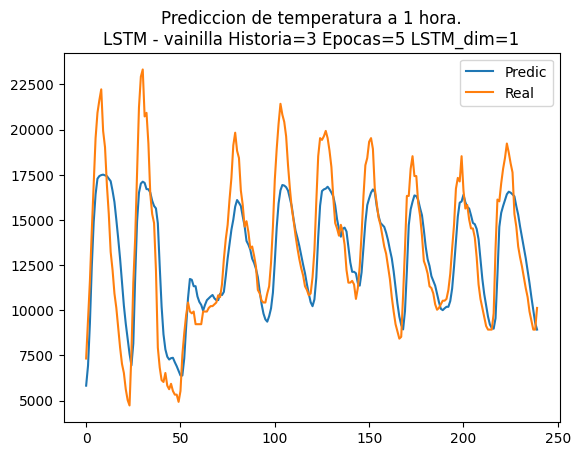

In [ ]:
Visualiza ("LSTM - vainilla")

## LSTM apiladas

In [ ]:
historia = 1
trainX, trainY = CreaDatos (train, historia)
testX, testY   = CreaDatos (test, historia)

print (trainX.shape)

# Crear y ajustar la red

model = Sequential()
model.add(LSTM(2, input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=True))
model.add(LSTM(2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY[:,3], epochs=EPOCAS, batch_size=BATCHSIZE, verbose=2)

(2149, 1, 6)
Epoch 1/5
2149/2149 - 5s - loss: 0.0151 - 5s/epoch - 2ms/step
Epoch 2/5
2149/2149 - 3s - loss: 0.0041 - 3s/epoch - 1ms/step
Epoch 3/5
2149/2149 - 3s - loss: 0.0022 - 3s/epoch - 1ms/step
Epoch 4/5
2149/2149 - 3s - loss: 0.0015 - 3s/epoch - 1ms/step
Epoch 5/5
2149/2149 - 3s - loss: 0.0013 - 3s/epoch - 2ms/step


1059/1059 [==============================] - 2s 1ms/step
Test Score: 1.63 RMSE


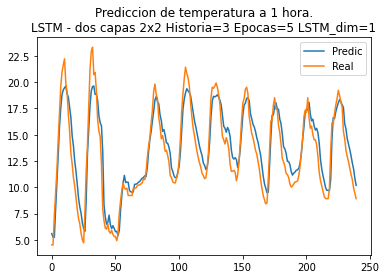

In [ ]:
Visualiza ("LSTM - dos capas 2x2")

## LSTM con memoria entre lote y lote



In [ ]:
# Crear y entrenar la red
batch_size = 1
model = Sequential()
model.add(LSTM(LSTM_dim, batch_input_shape=(batch_size, trainX.shape [1], trainX.shape [2]), stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(EPOCAS):
    model.fit(trainX, trainY[:,3], epochs=1, batch_size=BATCHSIZE, verbose=2, shuffle=False)
    model.reset_states()


2149/2149 - 4s - loss: 0.0140 - 4s/epoch - 2ms/step
2149/2149 - 2s - loss: 0.0122 - 2s/epoch - 1ms/step
2149/2149 - 2s - loss: 0.0098 - 2s/epoch - 1ms/step
2149/2149 - 2s - loss: 0.0075 - 2s/epoch - 1ms/step
2149/2149 - 2s - loss: 0.0057 - 2s/epoch - 1ms/step


1059/1059 [==============================] - 1s 1ms/step
Test Score: 3.32 RMSE


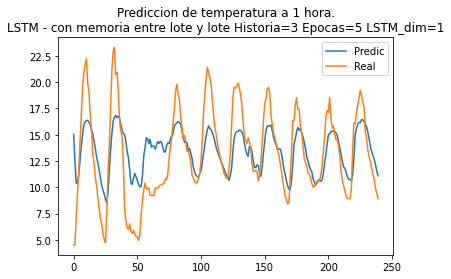

In [ ]:
Visualiza ("LSTM - con memoria entre lote y lote")

## LSTM's apilados (varias capas) con memoria entre lote y lote


In [ ]:
# Crear y ajustar la red
batch_size = 1
model = Sequential()
model.add(LSTM(2, batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(2, batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(EPOCAS):
    model.fit(trainX, trainY[:,3], epochs=1, batch_size=BATCHSIZE, verbose=2, shuffle=False)
    model.reset_states()

2149/2149 - 6s - loss: 0.0122 - 6s/epoch - 3ms/step
2149/2149 - 3s - loss: 0.0076 - 3s/epoch - 2ms/step
2149/2149 - 3s - loss: 0.0036 - 3s/epoch - 2ms/step
2149/2149 - 4s - loss: 0.0018 - 4s/epoch - 2ms/step
2149/2149 - 4s - loss: 0.0011 - 4s/epoch - 2ms/step


1059/1059 [==============================] - 2s 1ms/step
Test Score: 1.55 RMSE


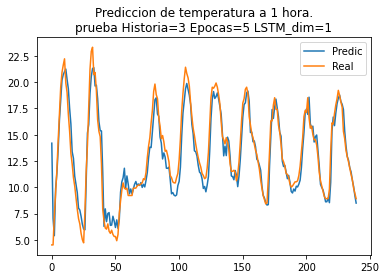

In [ ]:
Visualiza ("prueba")